# Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
def date_index(df):
    df['DATE'] = pd.to_datetime(df.DATE)
    df = df.set_index('DATE')
    return df

In [3]:
ffr = date_index(pd.read_csv('FEDFUNDS.csv'))
ffr = ffr/100
ffr.tail()

,FEDFUNDS
DATE,
2023-11-01,0.0533
2023-12-01,0.0533
2024-01-01,0.0533
2024-02-01,0.0533
2024-03-01,0.0533


In [4]:
cpi = date_index(pd.read_csv('CPIAUCSL.csv'))
cpi = cpi.apply(np.log).diff().rolling(12).sum()
cpi.tail()

,CPIAUCSL
DATE,
2023-10-01,0.031942
2023-11-01,0.030912
2023-12-01,0.032691
2024-01-01,0.030587
2024-02-01,0.031167


In [5]:
pce = date_index(pd.read_csv('PCEPI.csv'))
pce = pce.apply(np.log).diff().rolling(12).sum()
pce.tail()

,PCEPI
DATE,
2023-10-01,0.028996
2023-11-01,0.026668
2023-12-01,0.025857
2024-01-01,0.024034
2024-02-01,0.024213


In [6]:
gdp = date_index(pd.read_csv('GDPC1.csv'))
gdp = gdp.apply(np.log).diff().rolling(3).sum()
gdp.tail()

,GDPC1
DATE,
2022-10-01,0.011485
2023-01-01,0.018447
2023-04-01,0.016981
2023-07-01,0.022515
2023-10-01,0.025315


In [7]:
gdppot = date_index(pd.read_csv('GDPPOT.csv'))
gdppot = gdppot.apply(np.log).diff().rolling(3).sum()
gdppot.tail()

,GDPPOT
DATE,
2033-10-01,0.013704
2034-01-01,0.013603
2034-04-01,0.013522
2034-07-01,0.013422
2034-10-01,0.013345


In [8]:
nrou = date_index(pd.read_csv('NROU.csv'))
nrou = nrou/100
nrou.tail()

,NROU
DATE,
2033-10-01,0.042273
2034-01-01,0.042214
2034-04-01,0.042154
2034-07-01,0.042093
2034-10-01,0.042031


In [9]:
unrate = date_index(pd.read_csv('UNRATE.csv'))
unrate = unrate/100
unrate.tail()

,UNRATE
DATE,
2023-11-01,0.037
2023-12-01,0.037
2024-01-01,0.037
2024-02-01,0.039
2024-03-01,0.038


In [10]:
df = pd.concat([ffr, cpi, pce, gdp, gdppot, nrou, unrate],axis=1)
start = max([df[s].dropna().index.min() for s in df.columns])
end = min([df[s].dropna().index.max() for s in df.columns])
df = df.interpolate().loc[start:end]

<Axes: xlabel='DATE'>

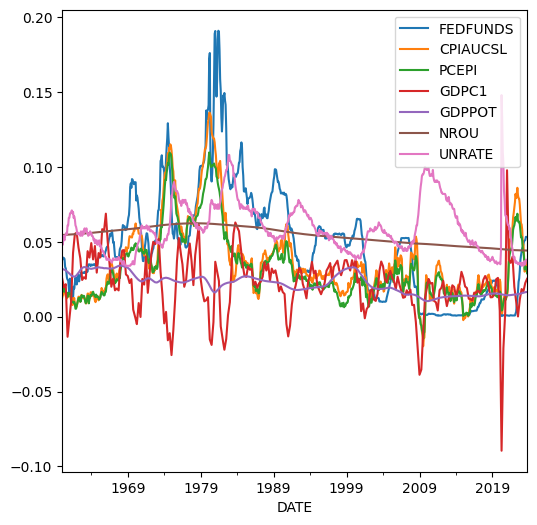

In [11]:
df.plot(figsize=(6, 6))

# Time Series Model

In [12]:
from statsmodels.tsa.arima.model import ARIMA

df['AR(1)']         = ARIMA(df['FEDFUNDS'].apply(np.log).diff(), order=(1, 0, 0), freq='MS').fit().predict()
df['MA(1)']         = ARIMA(df['FEDFUNDS'].diff(), order=(0, 0, 1), freq='MS').fit().predict()
df['ARMA(1,1)']     = ARIMA(df['FEDFUNDS'].apply(np.log).diff(), order=(1, 0, 1), freq='MS').fit().predict()
df['ARMA(3,0,7)']   = ARIMA(df['FEDFUNDS'].diff(), order=(3, 0, 7), freq='MS').fit().predict()
df['ARMA(14,0,4)']  = ARIMA(df['FEDFUNDS'].diff(), order=(14, 0, 4), freq='MS').fit().predict()

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will b

# Econometric Model

#### Fed's Interpretation of Full Employment Mandate
https://www.clevelandfed.org/publications/economic-commentary/2014/ec-201402-using-an-improved-taylor-rule-to-predict-when-policy-changes-will-occur
- We replace the Taylor Rule's assumption of Real GDP with Non-cyclical Unemployment.
- We assume that the Fed uses the 10 year moving average as the "Trend Unemployment" in their mandate to maximize "full employment"

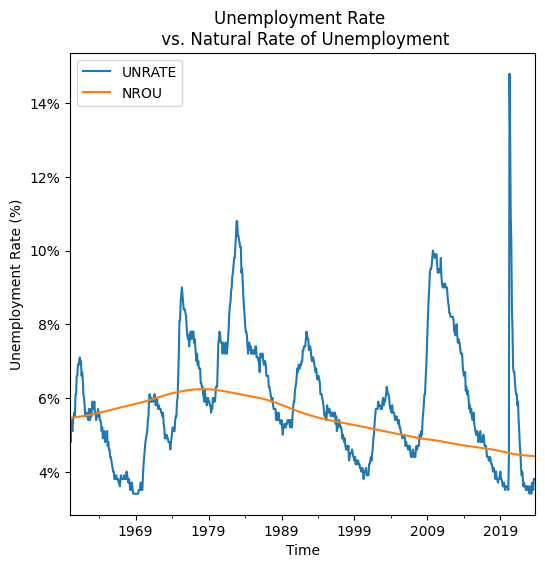

In [13]:
ax = df[['UNRATE','NROU']].plot(figsize=(6, 6))

# Adding title and labels
plt.title('Unemployment Rate \n vs. Natural Rate of Unemployment')
plt.xlabel('Time')
plt.ylabel('Unemployment Rate (%)')

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

plt.show()

#### Fed's Interpretation of Price Stability Mandate
https://www.stlouisfed.org/publications/regional-economist/july-2013/cpi-vs-pce-inflation--choosing-a-standard-measure
- We assume that the Fed uses PCE as their measure of inflation since January 24th, 2000
- We assume that the Fed uses CPI as their measure of inflation prior to 2000

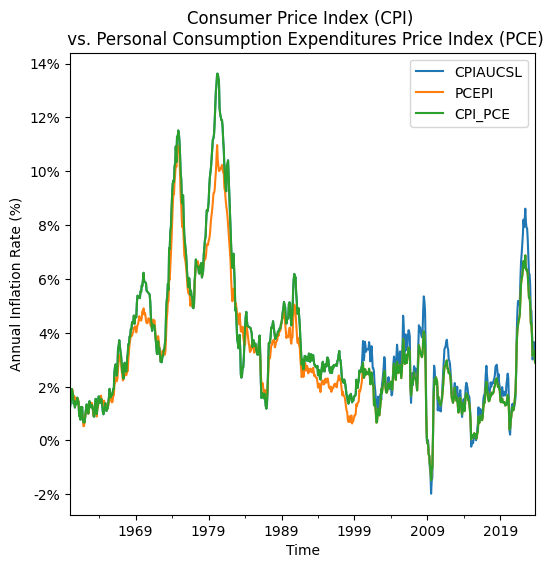

In [14]:
df['CPI_PCE'] = pd.concat([df.loc[:'2000-01-01','CPIAUCSL'], df.loc['2000-02-01':,'PCEPI']])

ax = df[['CPIAUCSL','PCEPI','CPI_PCE']].plot(figsize=(6, 6))

plt.title('Consumer Price Index (CPI) \n vs. Personal Consumption Expenditures Price Index (PCE)')
plt.xlabel('Time')
plt.ylabel('Annual Inflation Rate (%)')

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

plt.show()

# Taylor Rule

#### Taylor Rule
https://web.stanford.edu/~johntayl/Papers/Discretion.PDF  
https://serc.carleton.edu/sp/library/FRED/examples/97477.html
- We assume that the Taylor Rule is the benchmark over which the Fed Makes Discretionary Policy Decisions
- The Taylor Rule assumes that the Fed targets an inflation rate of 2%
- In his 1993 paper, Taylor assumes that the Fed targets a Real GDP rate in line with "Trend GDP" defined as the average over the previous 10 years.

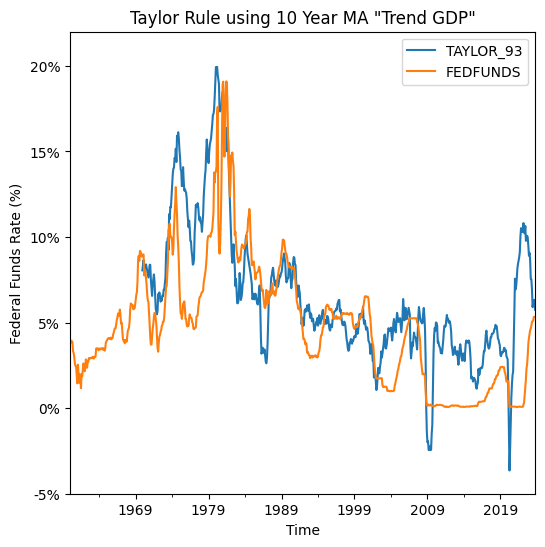

In [15]:
target = 0.02
df['TAYLOR_93'] = df['CPI_PCE'] + 0.5*(df['GDPC1']-df['GDPC1'].rolling(120).mean()) + 0.5*(df['CPI_PCE']-target) + target

ax = df[['TAYLOR_93','FEDFUNDS']].plot(figsize=(6, 6))

plt.title('Taylor Rule using 10 Year MA "Trend GDP"')
plt.xlabel('Time')
plt.ylabel('Federal Funds Rate (%)')

ax.set_ylim(-0.05, 0.22)  # Adjust as needed

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

plt.show()

- An alternative of interpretation of Trend GDP is to use the Congressional Budget Office's estimate for Real GDP Potential

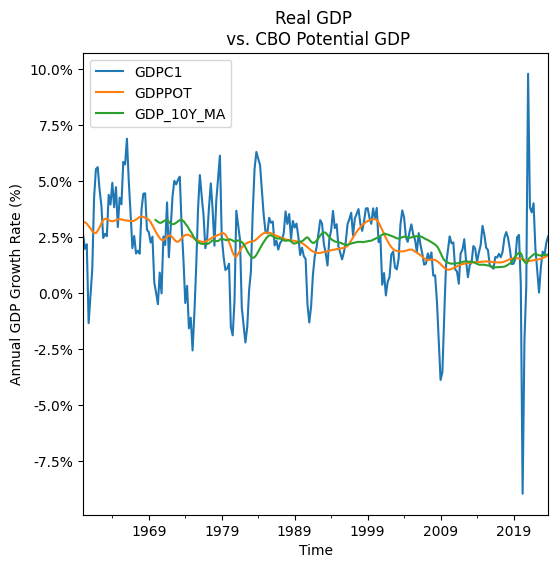

In [16]:
df['GDP_10Y_MA'] = df['GDPC1'].rolling(120).mean()

ax = df[['GDPC1','GDPPOT','GDP_10Y_MA']].plot(figsize=(6, 6))

plt.title('Real GDP \n vs. CBO Potential GDP')
plt.xlabel('Time')
plt.ylabel('Annual GDP Growth Rate (%)')

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:.1%}'.format(x)))

plt.show()

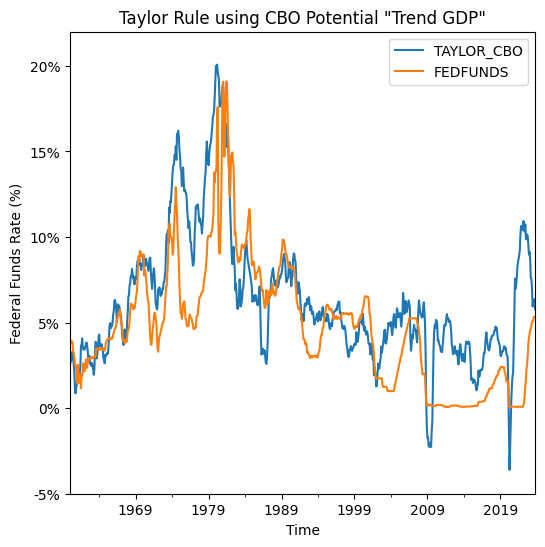

In [17]:
target = 0.02
df['TAYLOR_CBO'] = df['CPI_PCE'] + 0.5*(df['GDPC1']-df['GDPPOT']) + 0.5*(df['CPI_PCE']-target) + target

ax = df[['TAYLOR_CBO','FEDFUNDS']].plot(figsize=(6, 6))

plt.title('Taylor Rule using CBO Potential "Trend GDP"')
plt.xlabel('Time')
plt.ylabel('Federal Funds Rate (%)')

ax.set_ylim(-0.05, 0.22)  # Adjust as needed

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

plt.show()

- Apply the Fed's use of Unemployment in place of GDP

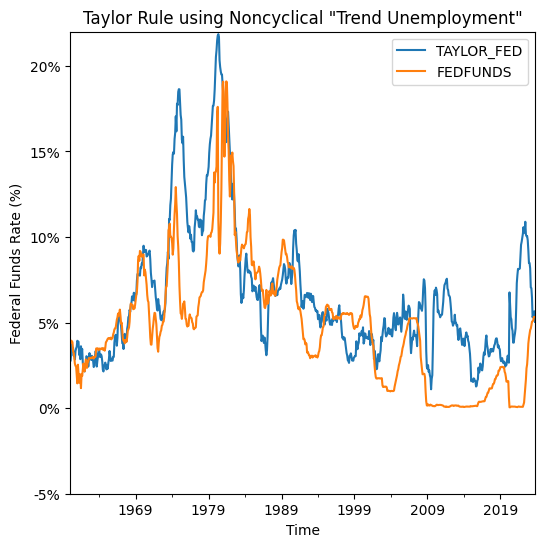

In [18]:
target = 0.02
df['TAYLOR_FED'] = df['CPI_PCE'] + 0.5*(df['UNRATE']-df['NROU']) + 0.5*(df['CPI_PCE']-target) + target

ax = df[['TAYLOR_FED','FEDFUNDS']].plot(figsize=(6, 6))

plt.title('Taylor Rule using Noncyclical "Trend Unemployment"')
plt.xlabel('Time')
plt.ylabel('Federal Funds Rate (%)')

ax.set_ylim(-0.05, 0.22)  # Adjust as needed

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

plt.show()

#### Policy Move Predictive Performance
https://www.clevelandfed.org/publications/economic-commentary/2014/ec-201402-using-an-improved-taylor-rule-to-predict-when-policy-changes-will-occur
- We borrow methodology from Fed's analysis of the Taylor Rule: 
    - They assume if the Taylor Rule is more than 150bps greater than the current Fed Funds rate, the Fed will raise the rate in the next quarter. 
    - If less than 150 bps, but the Fed raised in the previous quarter, then they will raise again.
    - 150 bps is empirically, but heuristically chosen by the Fed as a "significant deviation"

- We generalize this methodology using Logistic Regression
    - Response: [-1,0,1] The Fed Raise/Lowers the rate in the next quarter
    - Regressors:
        - Spread between Model (Taylor Rule) and Actual Fed Funds Rate
        - Previous Quarter's Response
        
- We then compare the predictive performance of the Taylor Rule vs our ARIMA model.


<Axes: xlabel='DATE'>

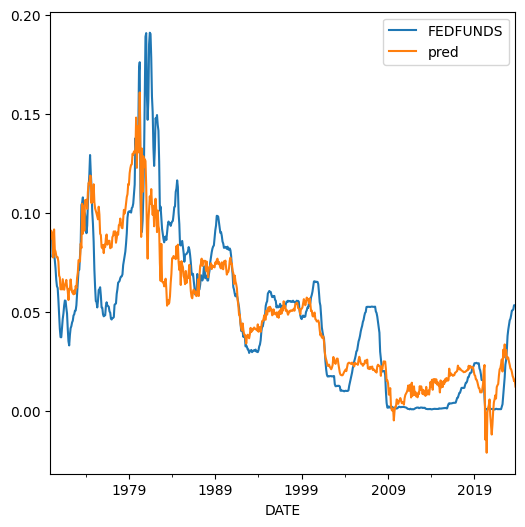

In [19]:
from sklearn.linear_model import LinearRegression

X = df.dropna()[[c for c in df.columns if c!='FEDFUNDS']]
y = df.dropna()['FEDFUNDS']

model = LinearRegression()
model.fit(X,y)

r = pd.DataFrame()
r[y.name] = y
r['pred'] = model.predict(X)

r.plot(figsize=(6, 6))

In [20]:
from sklearn.linear_model import LogisticRegression

def expand_regression(model, X, y):
    results = {}
    for i in range(len(X)):
        try:
            # Select features and target variable
            X_train = X.iloc[:i-1]
            y_train = y.iloc[:i-1]

            X_test = pd.DataFrame(X.iloc[i]).T

            # Fit the model on the training data
            model.fit(X_train, y_train)

            # Predict on the testing data
            results[X.index[i]] = model.predict(X_test)[0]

        except Exception as e:
            print(f'{type(e)}: {e}')

    return pd.DataFrame.from_dict(results, orient='index')[0]

def evaluate_model(model: str):
    data = pd.DataFrame()
    data['POLICY'] = (df['FEDFUNDS'] - df['FEDFUNDS'].shift(3)).apply(np.sign)
    data['POLICY_LAST'] = data['POLICY'].shift(3)
    data['SPREAD'] = df['FEDFUNDS'] - df[model]
    data = data.dropna()

    regression = expand_regression(
        model=LogisticRegression(),
        X=data[['POLICY_LAST','SPREAD']],
        y=data['POLICY']
    )

    eval = pd.DataFrame()
    eval['POLICY'] = data['POLICY']
    eval['PRED'] = regression
    eval['ACCURACY'] = (eval.POLICY==eval.PRED)*1

    return eval['ACCURACY']

In [21]:
eval = pd.DataFrame()
eval['TAYLOR_93']    = evaluate_model('TAYLOR_93')
eval['TAYLOR_CBO']   = evaluate_model('TAYLOR_CBO')
eval['TAYLOR_FED']   = evaluate_model('TAYLOR_FED')
eval['AR(1)']        = evaluate_model('AR(1)')
eval['MA(1)']        = evaluate_model('MA(1)')
eval['ARMA(1,1)']    = evaluate_model('ARMA(1,1)')
eval['ARMA(3,0,7)']  = evaluate_model('ARMA(3,0,7)')
eval['ARMA(14,0,4)'] = evaluate_model('ARMA(14,0,4)')


<class 'ValueError'>: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by LogisticRegression.
<class 'ValueError'>: This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1.0
<class 'ValueError'>: This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1.0
<class 'ValueError'>: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by LogisticRegression.
<class 'ValueError'>: This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1.0
<class 'ValueError'>: This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1.0
<class 'ValueError'>: This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1.0
<class 'ValueError'>: This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1.0


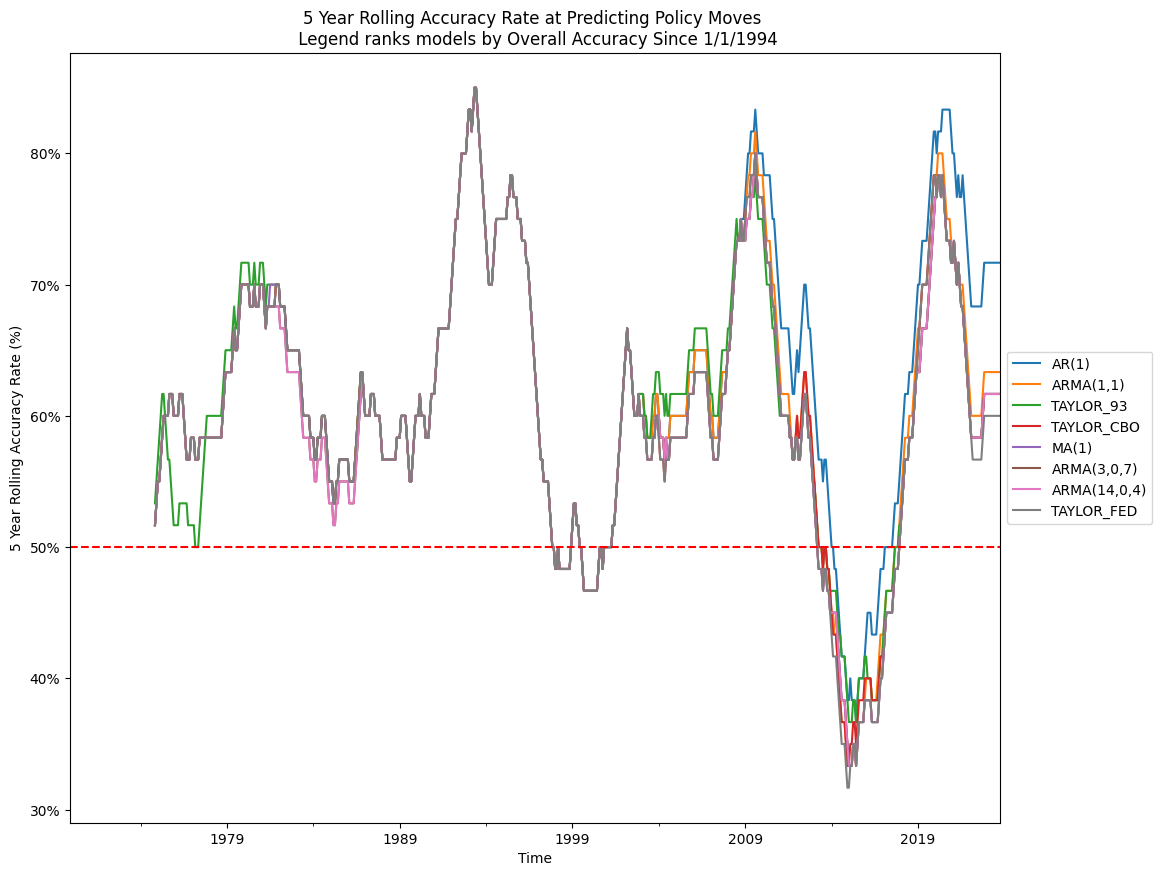

In [22]:
import matplotlib.pyplot as plt

# Plot DataFrame
ax = eval[[e for e in eval.loc['1994-01-01':].mean().sort_values(ascending=False).index]].rolling(60).mean().plot(figsize=(15, 10))

plt.title('5 Year Rolling Accuracy Rate at Predicting Policy Moves \n Legend ranks models by Overall Accuracy Since 1/1/1994')
plt.xlabel('Time')
plt.ylabel('5 Year Rolling Accuracy Rate (%)')

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

# Draw horizontal line at y=0.5
ax.axhline(y=0.5, color='r', linestyle='--')  # Adjust color and linestyle as needed

# Place legend outside the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))